# Phase 4: Estrous Cycle Discovery (Vehicle Cages Only)
## Cycle-aware inference from Envision video-derived behavioral bouts (Morph2REP Study 1001 v2025v3.3)

### High-level goal
We **do not have ground-truth estrous stage labels** (no vaginal cytology).  
Instead, we want to discover whether the dataset contains a **within-mouse ~4–5 day cyclic signal** consistent with an estrous cycle, using **video-derived behavioral bouts** and **cycle-aware modeling**.

### Core idea
1. Build a daily behavioral feature table aligned to the facility light cycle (6am–6pm EST; data timestamps are UTC).
2. Normalize **within mouse** (both simple z-score and a leakage-safe rolling baseline).
3. Reduce dimensionality (PCA).
4. Fit a **4-state time-aware model** (HMM) to infer latent states per day.
5. Validate that inferred states show:
   - **within-mouse periodicity** near 4–5 days,
   - **reasonable dwell times**, and
   - minimal confounding by **cage/date artifacts**.

### Data used in this notebook
We follow your previous notebook's loading approach (DuckDB `read_parquet` directly from S3) and start with the same two tables:
- `animal_bouts.parquet`: start/end times and bout durations for behavior states
- `animal_bout_metrics.parquet`: additional bout-level metrics (when available)

This notebook is scoped to **vehicle cages only** (controls), because drug perturbations can dominate variance.

---
## 1. Setup: packages and imports
We install and import the Python packages used for:
- querying parquet on S3 (DuckDB + PyArrow)
- feature engineering (Pandas/Numpy)
- modeling (scikit-learn + optional `hmmlearn`)
- statistics (SciPy)
- plotting (Matplotlib)

> If `hmmlearn` fails to install in your environment, you can still run everything up through PCA and periodicity checks.

In [1]:
# Install required packages (quiet)
!pip -q install duckdb pyarrow pandas numpy scikit-learn scipy matplotlib hmmlearn

In [2]:
import warnings
warnings.filterwarnings("ignore")

import duckdb
import numpy as np
import pandas as pd

from datetime import date, datetime, timedelta
from typing import List, Tuple

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from scipy.signal import lombscargle

---
## 2. Configuration: dataset paths, vehicle cages, and analysis windows
We keep the same conventions as your last notebook:

- S3 base path: `s3://jax-envision-public-data/study_1001/2025v3.3/tabular`
- Vehicle cages:
  - Rep 1: 4918, 4922, 4923
  - Rep 2: 4928, 4929, 4934
- Start after acclimation (3 days)
- Exclude the **cage change day** (environmental perturbation)

### Time alignment
Facility schedule is **EST**:
- Lights ON 6:00 AM EST
- Lights OFF 6:00 PM EST

Data timestamps are stored in **UTC**. EST = UTC − 5 hours, so:
- 6:00 AM EST = 11:00 UTC
- 6:00 PM EST = 23:00 UTC

We define a **circadian day** as 11:00 UTC → next day 11:00 UTC (i.e., 6am→6am EST).

In [3]:
S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

VEHICLE_CAGES = {
    "Rep1": {
        "cages": [4918, 4922, 4923],
        "analysis_start": "2025-01-10",  # after acclimation (Jan 7–9)
        "analysis_end": "2025-01-22",
        "cage_change": date(2025, 1, 15),
    },
    "Rep2": {
        "cages": [4928, 4929, 4934],
        "analysis_start": "2025-01-25",  # after acclimation (Jan 22–24)
        "analysis_end": "2025-02-04",
        "cage_change": date(2025, 1, 29),
    },
}

# Light cycle boundaries in UTC
LIGHTS_ON_UTC = 11   # 6:00 AM EST
LIGHTS_OFF_UTC = 23  # 6:00 PM EST

# Circadian day anchor: 6am EST (11:00 UTC)
CIRCADIAN_DAY_START_HOUR_UTC = LIGHTS_ON_UTC

print("Vehicle cages and analysis windows")
print("="*70)
for rep, cfg in VEHICLE_CAGES.items():
    print(f"{rep}: cages={cfg['cages']}, window={cfg['analysis_start']}..{cfg['analysis_end']}, exclude={cfg['cage_change']}")

Vehicle cages and analysis windows
Rep1: cages=[4918, 4922, 4923], window=2025-01-10..2025-01-22, exclude=2025-01-15
Rep2: cages=[4928, 4929, 4934], window=2025-01-25..2025-02-04, exclude=2025-01-29


---
## 3. Data loading utilities (DuckDB → Pandas)
We read parquet partitions from S3 with DuckDB `read_parquet`, matching your previous notebook.
We load:
- `animal_bouts.parquet`
- `animal_bout_metrics.parquet`

We attach `cage_id` and `date` columns to support day-based filtering.

In [4]:
def date_range(start: str, end: str) -> List[date]:
    start_d = datetime.strptime(start, "%Y-%m-%d").date()
    end_d = datetime.strptime(end, "%Y-%m-%d").date()
    out = []
    d = start_d
    while d <= end_d:
        out.append(d)
        d += timedelta(days=1)
    return out

def load_table_for_cages_dates(table_name: str, cages: List[int], dates: List[date]) -> pd.DataFrame:
    conn = duckdb.connect(database=":memory:")
    all_data = []

    for cage_id in cages:
        for d in dates:
            date_str = d.strftime("%Y-%m-%d")
            path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{table_name}"
            try:
                df = conn.execute(f"SELECT * FROM read_parquet('{path}')").fetchdf()
                df["cage_id"] = cage_id
                df["date"] = date_str
                all_data.append(df)
            except Exception:
                continue

    conn.close()
    if not all_data:
        return pd.DataFrame()
    return pd.concat(all_data, ignore_index=True)

---
## 4. Load vehicle-only bouts data
We load bouts and bout metrics across the analysis windows, excluding cage-change days.

In [5]:
TABLE_BOUTS = "animal_bouts.parquet"
TABLE_BOUT_METRICS = "animal_bout_metrics.parquet"

def load_vehicle_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    all_bouts = []
    all_metrics = []

    for rep, cfg in VEHICLE_CAGES.items():
        cages = cfg["cages"]
        days = date_range(cfg["analysis_start"], cfg["analysis_end"])
        days = [d for d in days if d != cfg["cage_change"]]  # exclude cage change

        df_b = load_table_for_cages_dates(TABLE_BOUTS, cages, days)
        df_m = load_table_for_cages_dates(TABLE_BOUT_METRICS, cages, days)

        if not df_b.empty:
            df_b["replicate"] = rep
            all_bouts.append(df_b)
        if not df_m.empty:
            df_m["replicate"] = rep
            all_metrics.append(df_m)

    bouts = pd.concat(all_bouts, ignore_index=True) if all_bouts else pd.DataFrame()
    metrics = pd.concat(all_metrics, ignore_index=True) if all_metrics else pd.DataFrame()
    return bouts, metrics

df_bouts, df_metrics = load_vehicle_data()

print("Loaded rows:")
print(f"  animal_bouts:        {len(df_bouts):,}")
print(f"  animal_bout_metrics: {len(df_metrics):,}")

df_bouts.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded rows:
  animal_bouts:        10,706,335
  animal_bout_metrics: 9,291,062


,predicted_identity,start_time,end_time,state_name,organization_id,cage_id,study_id,device_id,animal_id,bout_length_seconds,source_file,date,replicate
0,browncheckered,2025-01-10 05:00:00,2025-01-10 05:00:57,animal_bouts.active,8,4918,1001,deepgraph-manager-inject,9257,57,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-10,Rep1
1,redbarred,2025-01-10 05:00:00,2025-01-10 05:00:01,animal_bouts.active,8,4918,1001,deepgraph-manager-inject,9258,1,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-10,Rep1
2,blackallwhite,2025-01-10 05:00:00,2025-01-10 05:00:01,animal_bouts.climbing,8,4918,1001,deepgraph-manager-inject,9259,1,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-10,Rep1
3,blackallwhite,2025-01-10 05:00:01,2025-01-10 05:00:12,animal_bouts.active,8,4918,1001,deepgraph-manager-inject,9259,11,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-10,Rep1
4,redbarred,2025-01-10 05:00:01,2025-01-10 05:00:15,animal_bouts.inactive,8,4918,1001,deepgraph-manager-inject,9258,14,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-10,Rep1


---
## 5. Feature engineering: daily (6am→6am) features for light and dark
We build daily features aligned to a **circadian day** starting at 6am EST (11:00 UTC).
We compute features separately for light vs dark, then combine them into one row per mouse-day:
- per-state total duration (seconds)
- per-state bout count
- per-state mean bout length
- transition entropy (sequence fragmentation)

In [6]:
def to_utc(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, utc=True, errors="coerce")

def assign_circadian_day(ts_utc: pd.Series, day_start_hour_utc: int = 11) -> pd.Series:
    ts = pd.to_datetime(ts_utc, utc=True)
    shifted = ts - pd.to_timedelta(day_start_hour_utc, unit="h")
    return shifted.dt.date

def is_light(ts_utc: pd.Series, lights_on_utc: int = 11, lights_off_utc: int = 23) -> pd.Series:
    hrs = pd.to_datetime(ts_utc, utc=True).dt.hour
    return (hrs >= lights_on_utc) & (hrs < lights_off_utc)

def compute_daily_bout_features(df_bouts: pd.DataFrame,
                               day_start_hour_utc: int = 11,
                               lights_on_utc: int = 11,
                               lights_off_utc: int = 23) -> pd.DataFrame:
    df = df_bouts.copy()
    df["start_time"] = to_utc(df["start_time"])
    df["end_time"] = to_utc(df["end_time"])
    df = df.dropna(subset=["start_time", "end_time", "animal_id", "state_name", "bout_length_seconds"])

    df["circadian_day"] = assign_circadian_day(df["start_time"], day_start_hour_utc=day_start_hour_utc)
    df["period"] = np.where(is_light(df["start_time"], lights_on_utc, lights_off_utc), "light", "dark")
    df["state_short"] = df["state_name"].astype(str).str.split(".").str[-1]

    agg = df.groupby(["animal_id", "circadian_day", "period", "state_short"]).agg(
        total_duration_s=("bout_length_seconds", "sum"),
        bout_count=("bout_length_seconds", "size"),
        mean_bout_s=("bout_length_seconds", "mean"),
    ).reset_index()

    def pivot(period: str, value_col: str) -> pd.DataFrame:
        sub = agg[agg["period"] == period]
        wide = sub.pivot_table(index=["animal_id", "circadian_day"], columns="state_short",
                               values=value_col, aggfunc="first")
        wide.columns = [f"{c}_{value_col}_{period}" for c in wide.columns]
        return wide.reset_index()

    dur_l = pivot("light", "total_duration_s")
    dur_d = pivot("dark", "total_duration_s")
    cnt_l = pivot("light", "bout_count")
    cnt_d = pivot("dark", "bout_count")
    mb_l  = pivot("light", "mean_bout_s")
    mb_d  = pivot("dark", "mean_bout_s")

    # transition entropy per day-period
    from collections import Counter

    def transition_entropy(g: pd.DataFrame) -> float:
        g = g.sort_values("start_time")
        s = g["state_short"].to_numpy()
        if len(s) < 2:
            return 0.0
        pairs = list(zip(s[:-1], s[1:]))
        c = Counter(pairs)
        p = np.array(list(c.values()), dtype=float)
        p = p / p.sum()
        return float(-(p * np.log2(p)).sum())

    ent = df.groupby(["animal_id", "circadian_day", "period"]).apply(transition_entropy).reset_index()
    ent = ent.rename(columns={0: "transition_entropy"})

    ent_l = ent[ent["period"]=="light"][["animal_id","circadian_day","transition_entropy"]].rename(
        columns={"transition_entropy":"transition_entropy_light"}
    )
    ent_d = ent[ent["period"]=="dark"][["animal_id","circadian_day","transition_entropy"]].rename(
        columns={"transition_entropy":"transition_entropy_dark"}
    )

    out = dur_l.merge(dur_d, on=["animal_id","circadian_day"], how="outer")
    for piece in [cnt_l, cnt_d, mb_l, mb_d, ent_l, ent_d]:
        out = out.merge(piece, on=["animal_id","circadian_day"], how="outer")

    return out

daily_features = compute_daily_bout_features(
    df_bouts,
    day_start_hour_utc=CIRCADIAN_DAY_START_HOUR_UTC,
    lights_on_utc=LIGHTS_ON_UTC,
    lights_off_utc=LIGHTS_OFF_UTC,
)

print("Daily features shape:", daily_features.shape)
daily_features.head()

Daily features shape: (257, 70)


,animal_id,circadian_day,active_total_duration_s_light,climbing_total_duration_s_light,drinking_total_duration_s_light,feeding_total_duration_s_light,in_proximity_other_total_duration_s_light,inactive_total_duration_s_light,inferred_sleep_total_duration_s_light,isolated_all_total_duration_s_light,...,feeding_mean_bout_s_dark,in_proximity_other_mean_bout_s_dark,inactive_mean_bout_s_dark,inferred_sleep_mean_bout_s_dark,isolated_all_mean_bout_s_dark,isolated_other_mean_bout_s_dark,locomotion_mean_bout_s_dark,proximal_all_mean_bout_s_dark,transition_entropy_light,transition_entropy_dark
0,0,2025-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.484058,NaN,NaN,1.0,1.458515,NaN,1.0,NaN,1.626803
1,0,2025-01-10,NaN,NaN,NaN,NaN,16453.0,NaN,NaN,3739.0,...,NaN,2.316467,NaN,NaN,1.0,1.556962,NaN,1.0,1.567755,2.124811
2,0,2025-01-11,NaN,NaN,NaN,NaN,20270.0,NaN,NaN,2881.0,...,NaN,2.370137,NaN,NaN,1.0,1.442882,NaN,1.0,1.956200,1.867075
3,0,2025-01-12,NaN,NaN,NaN,NaN,21608.0,NaN,NaN,4133.0,...,NaN,2.349701,NaN,NaN,1.0,1.346705,NaN,1.0,1.728404,1.951738
4,0,2025-01-13,NaN,NaN,NaN,NaN,20182.0,NaN,NaN,3630.0,...,NaN,2.380878,NaN,NaN,1.0,1.553073,NaN,1.0,1.820582,2.359065


---
## 6. Within-mouse normalization (simple z-score + leakage-safe rolling z-score)
Estrous is a within-mouse cycle, so we compute:
1) **raw daily metrics**
2) **within-mouse z-scores** (feature-wise across days)
3) **rolling z-scores** using only past days (window=5; min 3 prior days)

In [7]:
key_cols = ["animal_id", "circadian_day"]
feature_cols = [c for c in daily_features.columns if c not in key_cols]

df_daily = daily_features.copy()
df_daily["circadian_day"] = pd.to_datetime(df_daily["circadian_day"])
df_daily = df_daily.sort_values(["animal_id", "circadian_day"])

def within_mouse_z(df: pd.DataFrame, feats: List[str]) -> pd.DataFrame:
    out = df.copy()
    for f in feats:
        out[f] = out.groupby("animal_id")[f].transform(lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-8))
    return out

def rolling_z_past(df: pd.DataFrame, feats: List[str], window: int = 5, min_periods: int = 3) -> pd.DataFrame:
    out = df.copy()
    for f in feats:
        g = out.groupby("animal_id")[f]
        mu = g.shift(1).rolling(window=window, min_periods=min_periods).mean()
        sd = g.shift(1).rolling(window=window, min_periods=min_periods).std(ddof=0)
        out[f] = (out[f] - mu) / (sd + 1e-8)
    return out

df_within = within_mouse_z(df_daily, feature_cols)
df_roll   = rolling_z_past(df_daily, feature_cols, window=5, min_periods=3)

display(df_daily.head(3))
display(df_within.head(3))
display(df_roll.head(3))

,animal_id,circadian_day,active_total_duration_s_light,climbing_total_duration_s_light,drinking_total_duration_s_light,feeding_total_duration_s_light,in_proximity_other_total_duration_s_light,inactive_total_duration_s_light,inferred_sleep_total_duration_s_light,isolated_all_total_duration_s_light,...,feeding_mean_bout_s_dark,in_proximity_other_mean_bout_s_dark,inactive_mean_bout_s_dark,inferred_sleep_mean_bout_s_dark,isolated_all_mean_bout_s_dark,isolated_other_mean_bout_s_dark,locomotion_mean_bout_s_dark,proximal_all_mean_bout_s_dark,transition_entropy_light,transition_entropy_dark
0,0,2025-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.484058,NaN,NaN,1.0,1.458515,NaN,1.0,NaN,1.626803
1,0,2025-01-10,NaN,NaN,NaN,NaN,16453.0,NaN,NaN,3739.0,...,NaN,2.316467,NaN,NaN,1.0,1.556962,NaN,1.0,1.567755,2.124811
2,0,2025-01-11,NaN,NaN,NaN,NaN,20270.0,NaN,NaN,2881.0,...,NaN,2.370137,NaN,NaN,1.0,1.442882,NaN,1.0,1.956200,1.867075


,animal_id,circadian_day,active_total_duration_s_light,climbing_total_duration_s_light,drinking_total_duration_s_light,feeding_total_duration_s_light,in_proximity_other_total_duration_s_light,inactive_total_duration_s_light,inferred_sleep_total_duration_s_light,isolated_all_total_duration_s_light,...,feeding_mean_bout_s_dark,in_proximity_other_mean_bout_s_dark,inactive_mean_bout_s_dark,inferred_sleep_mean_bout_s_dark,isolated_all_mean_bout_s_dark,isolated_other_mean_bout_s_dark,locomotion_mean_bout_s_dark,proximal_all_mean_bout_s_dark,transition_entropy_light,transition_entropy_dark
0,0,2025-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.201368,NaN,NaN,0.0,-0.346950,NaN,0.0,NaN,-1.043127
1,0,2025-01-10,NaN,NaN,NaN,NaN,-0.744869,NaN,NaN,-0.080712,...,NaN,-0.893796,NaN,NaN,0.0,0.051986,NaN,0.0,-1.110366,0.335514
2,0,2025-01-11,NaN,NaN,NaN,NaN,-0.181932,NaN,NaN,-0.376597,...,NaN,-0.543074,NaN,NaN,0.0,-0.410299,NaN,0.0,0.341116,-0.377980


,animal_id,circadian_day,active_total_duration_s_light,climbing_total_duration_s_light,drinking_total_duration_s_light,feeding_total_duration_s_light,in_proximity_other_total_duration_s_light,inactive_total_duration_s_light,inferred_sleep_total_duration_s_light,isolated_all_total_duration_s_light,...,feeding_mean_bout_s_dark,in_proximity_other_mean_bout_s_dark,inactive_mean_bout_s_dark,inferred_sleep_mean_bout_s_dark,isolated_all_mean_bout_s_dark,isolated_other_mean_bout_s_dark,locomotion_mean_bout_s_dark,proximal_all_mean_bout_s_dark,transition_entropy_light,transition_entropy_dark
0,0,2025-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2025-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2025-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
## 7. Build the modeling matrix
We start with **within-mouse z-scores** as the default input to modeling.
We also:
- impute missing values (median)
- standardize across features
- reduce via PCA

X_scaled: (257, 68) X_pca_k: (257, 10)


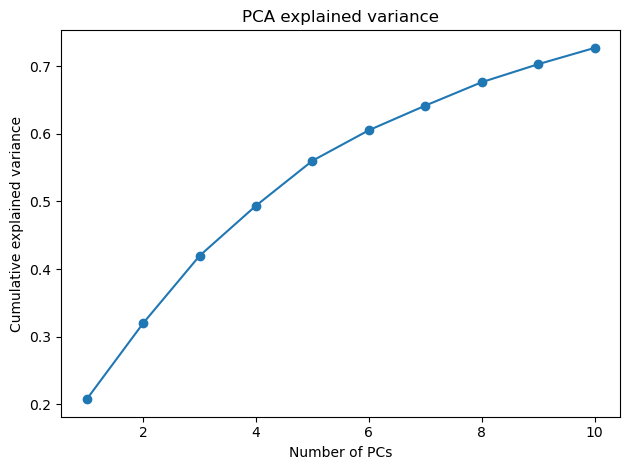

In [8]:
MODEL_DF = df_within.copy()   # swap to df_roll for rolling baseline

X = MODEL_DF[feature_cols].copy()

imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

pca = PCA(n_components=min(10, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

explained = np.cumsum(pca.explained_variance_ratio_)
k = int(np.searchsorted(explained, 0.85) + 1)
k = max(2, min(k, X_pca.shape[1]))
X_pca_k = X_pca[:, :k]

print("X_scaled:", X_scaled.shape, "X_pca_k:", X_pca_k.shape)

plt.figure()
plt.plot(np.arange(1, len(explained)+1), explained, marker="o")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance")
plt.tight_layout()
plt.show()

---
## 8. Fit a 4-state HMM (time-aware) and decode states
This replaces K-means. We expect estrous-like states to be persistent and to show cyclic recurrence.

In [9]:
states = None
post = None

try:
    from hmmlearn.hmm import GaussianHMM
    hmm_ok = True
except Exception as e:
    hmm_ok = False
    print("Could not import hmmlearn:", e)

if hmm_ok:
    n_states = 4
    model = GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=200,
        random_state=42
    )

    # initialize with sticky transitions
    transmat = np.full((n_states, n_states), 0.05 / (n_states - 1))
    np.fill_diagonal(transmat, 0.95)
    model.transmat_ = transmat
    model.startprob_ = np.full(n_states, 1.0 / n_states)

    model.fit(X_pca_k)
    states = model.predict(X_pca_k)
    post = model.predict_proba(X_pca_k)

    print("Learned transition matrix:")
    display(pd.DataFrame(model.transmat_))

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Learned transition matrix:


,0,1,2,3
0,0.000000e+00,0.000000,2.141657e-39,1.000000
1,8.306021e-278,0.360000,4.000000e-02,0.600000
2,2.836176e-78,0.108062,8.547739e-01,0.037164
3,1.516068e-01,0.073514,1.071188e-02,0.764167


---
## 9. Results table (mouse-day)
We attach inferred states back to the daily table.

In [10]:
results = MODEL_DF[["animal_id", "circadian_day"]].copy()
results["circadian_day"] = pd.to_datetime(results["circadian_day"]).dt.date

if states is not None:
    results["state"] = states
    results["state_conf"] = post.max(axis=1)
else:
    results["state"] = np.nan
    results["state_conf"] = np.nan

# Attach PC1 for rhythm testing
results["PC1"] = X_pca_k[:, 0]
results.head()

,animal_id,circadian_day,state,state_conf,PC1
0,0,2025-01-09,2,1.0,0.219868
1,0,2025-01-10,2,1.0,-0.333756
2,0,2025-01-11,2,1.0,-0.493566
3,0,2025-01-12,2,1.0,-0.609700
4,0,2025-01-13,2,1.0,-0.474279


---
## 10. Visualize per-mouse state trajectories
Heatmap: rows = mice, columns = days, values = inferred state.

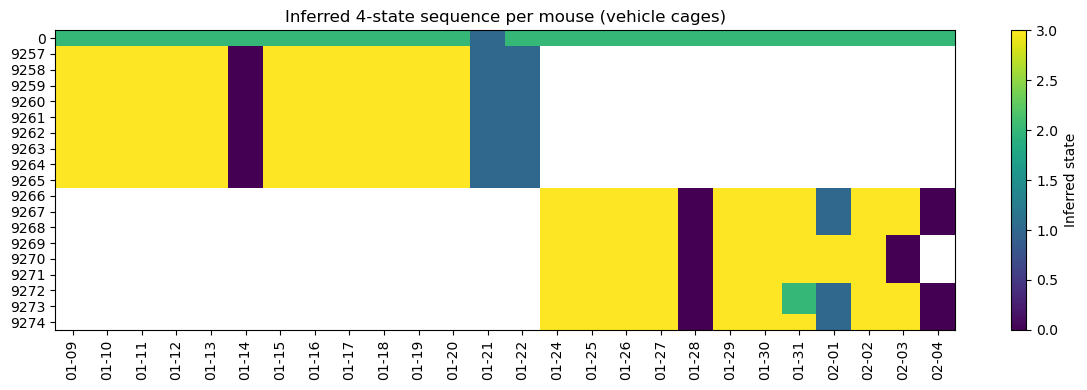

In [11]:
pivot = results.pivot_table(index="animal_id", columns="circadian_day", values="state", aggfunc="first").sort_index()

plt.figure(figsize=(12, max(4, 0.15 * len(pivot))))
plt.imshow(pivot.values, aspect="auto", interpolation="nearest")
plt.yticks(np.arange(len(pivot.index)), pivot.index)
plt.xticks(np.arange(len(pivot.columns)), [d.strftime("%m-%d") for d in pivot.columns], rotation=90)
plt.colorbar(label="Inferred state")
plt.title("Inferred 4-state sequence per mouse (vehicle cages)")
plt.tight_layout()
plt.show()

---
## 11. Periodicity test (per mouse) using Lomb–Scargle on PC1
We look for strongest period in the 2.5–8 day range and summarize across mice.

In [12]:
def lomb_scargle_best_period(t_days, y, min_period=2.5, max_period=8.0, n_freq=500):
    t = np.asarray(t_days, dtype=float)
    y = np.asarray(y, dtype=float)
    m = np.isfinite(t) & np.isfinite(y)
    t, y = t[m], y[m]
    if len(t) < 6:
        return np.nan

    periods = np.linspace(min_period, max_period, n_freq)
    freqs = 2 * np.pi / periods
    y0 = y - y.mean()
    pgram = lombscargle(t, y0, freqs, normalize=True)
    return float(periods[int(np.argmax(pgram))])

peaks = []
for aid, g in results.groupby("animal_id"):
    g = g.sort_values("circadian_day")
    t0 = pd.to_datetime(g["circadian_day"]).min()
    t_days = (pd.to_datetime(g["circadian_day"]) - t0).dt.days.values
    best = lomb_scargle_best_period(t_days, g["PC1"].values)
    peaks.append((aid, best))

peak_df = pd.DataFrame(peaks, columns=["animal_id", "best_period_days"]).dropna()
peak_df.describe()

,animal_id,best_period_days
count,19.000000,19.000000
mean,8777.842105,5.303660
std,2125.657814,1.387899
min,0.000000,3.007014
25%,9260.500000,4.605210
50%,9265.000000,5.101202
75%,9269.500000,6.737976
max,9274.000000,6.952906


---
## 12. Dwell times and transitions (sanity check)
Estrous-like states should not jump randomly day-to-day.
We compute:
- empirical transition matrix from decoded states
- dwell time distributions (run lengths)

In [13]:
res_sorted = results.sort_values(["animal_id", "circadian_day"])
trans_counts = np.zeros((4,4), dtype=int)
dwell = {s: [] for s in range(4)}

for aid, g in res_sorted.groupby("animal_id"):
    seq = g["state"].dropna().astype(int).values
    if len(seq) < 2:
        continue
    for a,b in zip(seq[:-1], seq[1:]):
        trans_counts[a,b] += 1
    cur = seq[0]; run = 1
    for x in seq[1:]:
        if x == cur:
            run += 1
        else:
            dwell[cur].append(run)
            cur = x; run = 1
    dwell[cur].append(run)

trans_prob = trans_counts / np.maximum(trans_counts.sum(axis=1, keepdims=True), 1)
display(pd.DataFrame(trans_prob))

print("Mean dwell length (days) per state:")
for s in range(4):
    vals = dwell[s]
    if vals:
        print(f"state {s}: mean={np.mean(vals):.2f}, n={len(vals)}")
    else:
        print(f"state {s}: no data")

,0,1,2,3
0,0.000000,0.000000,0.000000,1.000000
1,0.000000,0.562500,0.062500,0.375000
2,0.000000,0.115385,0.884615,0.000000
3,0.151685,0.073034,0.011236,0.764045


Mean dwell length (days) per state:
state 0: mean=1.00, n=27
state 1: mean=1.56, n=16
state 2: mean=6.75, n=4
state 3: mean=4.24, n=42


---
## 13. Export results
We save a CSV with inferred states and PC1 values for downstream analyses and plotting.

In [14]:
out_path = "/mnt/data/phase4_vehicle_cycle_states.csv"
results.to_csv(out_path, index=False)
print("Saved:", out_path)
results.head()

OSError: Cannot save file into a non-existent directory: '/mnt/data'

---
## 14. Next extensions (optional but recommended)
To strengthen estrous inference without labels:
1. Add modalities:
   - `animal_drinking` (consumption rhythms)
   - `animal_respiration` / `animal_tsdb_mvp`
   - `animal_sociability_pairwise`
2. Use a null test:
   - shuffle days within each mouse; confirm 4–5 day periodic peaks disappear
3. Move from sticky HMM → **cyclic-constrained** HMM (P→E→M→D→P) once periodicity is established.